In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from string import digits
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from hunspell import Hunspell
import os
import joblib
import tqdm
import contextlib

Para poder ver la barra de evolución en el multiproceso

In [55]:
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def _call_(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super()._call_(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [43]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alfonso/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [46]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/alfonso/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [37]:
nltk.download('words'); 
nltk.download('wordnet'); 
nltk.download('omw-1.4'); 
nltk.download('brown'); 
nltk.download('movie_reviews'); 
nltk.download('punkt'); 
nltk.download('treebank'); 
nltk.download('stopwords');

[nltk_data] Downloading package words to /home/alfonso/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /home/alfonso/nltk_data...
[nltk_data] Downloading package omw-1.4 to /home/alfonso/nltk_data...
[nltk_data] Downloading package brown to /home/alfonso/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/alfonso/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package punkt to /home/alfonso/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package treebank to /home/alfonso/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alfonso/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Lectura y análisis inicial de los datos

In [2]:
raw_data = pd.read_pickle("data/fillings/dataframe_10k_20_21_22.pkl")

In [3]:
raw_data.head()

,ticker,link_to_html,item_1,filing_date
0,NPHC,https://www.sec.gov/Archives/edgar/data/111964...,Item 1. Business Introduction We were incorpo...,2021
1,CACC,https://www.sec.gov/Archives/edgar/data/885550...,"ITEM 1. BUSINESS General Since 1972, Credit A...",2020
2,HII,https://www.sec.gov/Archives/edgar/data/150158...,ITEM 1. BUSINESS History and Organization Hun...,2020
3,HR,https://www.sec.gov/Archives/edgar/data/899749...,Item 1. Business Healthcare Realty Trust Inco...,2020
4,MNKPF,https://www.sec.gov/Archives/edgar/data/156789...,Item 1. Business. Overview We are a global bu...,2020


In [4]:
raw_data.shape

(16710, 4)

In [20]:
np.unique(raw_data["filing_date"], return_counts=True)

(array(['2020', '2021', '2022'], dtype=object), array([4904, 5758, 6048]))

Existen fillings duplicados. Los eliminamos

In [5]:
num_10k_ticker = pd.pivot_table(raw_data[["ticker", "filing_date"]], index="ticker", values="filing_date", aggfunc="count")
num_10k_ticker.sort_values("filing_date", ascending=False, inplace=True)
num_10k_ticker.where(num_10k_ticker.values > 3).dropna()

,filing_date
ticker,
SIPN,14.0
CNCN,11.0
PBAJ,9.0
SVMB,9.0
CGSI,8.0
...,...
IPTK,4.0
GNRS,4.0
CWGL,4.0


In [6]:
raw_data_unique = raw_data.drop_duplicates(subset=["ticker", "filing_date"])
raw_data_unique.shape

(15842, 4)

In [126]:
num_10k_ticker_unique = pd.pivot_table(raw_data_unique[["ticker", "filing_date"]], index="ticker", values="filing_date", aggfunc="count")
num_10k_ticker_unique.sort_values("filing_date", ascending=False, inplace=True)
num_10k_ticker_unique.where(num_10k_ticker.values > 3).dropna()

,filing_date
ticker,
KBSR,3.0
MSN,3.0
MTCH,3.0
MTBC,3.0
MTB,3.0
...,...
ONEM,3.0
ONDS,3.0
ONCT,3.0


### Separamos los datos por año

In [30]:
# separamos por año y eliminamos la columna fillin_date

raw_2020 = raw_data_unique[raw_data_unique["filing_date"] == "2020"].iloc[:, :-1]
raw_2021 = raw_data_unique[raw_data_unique["filing_date"] == "2021"].iloc[:, :-1]
raw_2022 = raw_data_unique[raw_data_unique["filing_date"] == "2022"].iloc[:, :-1]

In [8]:
print(f' El año 2020 tiene {raw_2020.shape[0]} ficheros 10-K')
print(f' El año 2021 tiene {raw_2021.shape[0]} ficheros 10-K')
print(f' El año 2022 tiene {raw_2022.shape[0]} ficheros 10-K')


 El año 2020 tiene 4703 ficheros 10-K
 El año 2021 tiene 5296 ficheros 10-K
 El año 2022 tiene 5843 ficheros 10-K


Número de palabras por cada 10K filling

In [9]:
num_words_2022 = raw_2022["item_1"].str.count(' ')
num_words_2021 = raw_2021["item_1"].str.count(' ')
num_words_2020 = raw_2020["item_1"].str.count(' ')

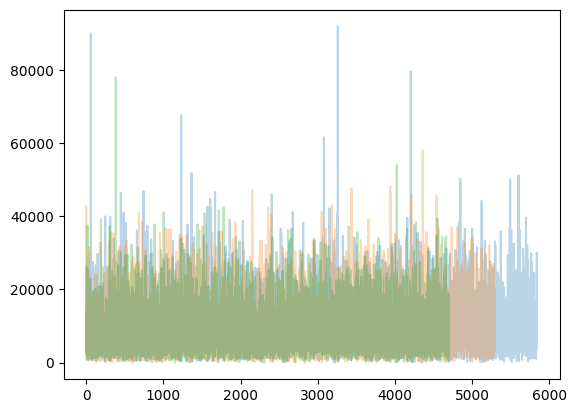

In [10]:
plt.plot(num_words_2022.values, alpha=0.3, label="2022")
plt.plot(num_words_2021.values, alpha=0.3, label="2021")
plt.plot(num_words_2020.values, alpha=0.3, label="2020")
plt.show()

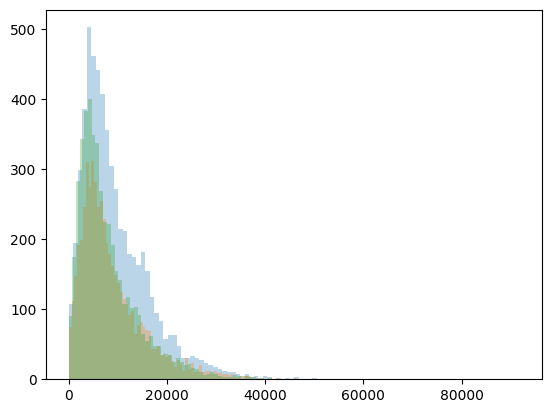

In [11]:
plt.hist(num_words_2022.values, bins=100, alpha=0.3, label="2022");
plt.hist(num_words_2021.values, bins=100, alpha=0.3);
plt.hist(num_words_2020.values, bins=100, alpha=0.3);

In [12]:
print(f'El número mínimo de palabras en un fichero 10-K del año 2022 es {np.min(num_words_2022.values)}')
print(f'El número máximo de palabras en un fichero 10-K del año 2022 es {np.max(num_words_2022.values)}')
print(f'El número medio de palabras en un fichero 10-K del año 2022 es {int(np.mean(num_words_2022.values))}')

El número mínimo de palabras en un fichero 10-K del año 2022 es 34
El número máximo de palabras en un fichero 10-K del año 2022 es 91803
El número medio de palabras en un fichero 10-K del año 2022 es 9683


In [13]:
print(f'El número mínimo de palabras en un fichero 10-K del año 2021 es {np.min(num_words_2021.values)}')
print(f'El número máximo de palabras en un fichero 10-K del año 2021 es {np.max(num_words_2021.values)}')
print(f'El número medio de palabras en un fichero 10-K del año 2021 es {int(np.mean(num_words_2021.values))}')

El número mínimo de palabras en un fichero 10-K del año 2021 es 17
El número máximo de palabras en un fichero 10-K del año 2021 es 57911
El número medio de palabras en un fichero 10-K del año 2021 es 8937


In [14]:
print(f'El número mínimo de palabras en un fichero 10-K del año 2020 es {np.min(num_words_2020.values)}')
print(f'El número máximo de palabras en un fichero 10-K del año 2020 es {np.max(num_words_2020.values)}')
print(f'El número medio de palabras en un fichero 10-K del año 2020 es {int(np.mean(num_words_2020.values))}')

El número mínimo de palabras en un fichero 10-K del año 2020 es 14
El número máximo de palabras en un fichero 10-K del año 2020 es 77974
El número medio de palabras en un fichero 10-K del año 2020 es 8137


## Limpieza inicial de los textos del año 2022

In [47]:
stop_words = set(stopwords.words('english'))

In [31]:
clean_2022 = raw_2022.copy()

In [32]:
clean_2022["item_1"] = clean_2022["item_1"].str.translate(str.maketrans('', '',string.punctuation))

In [33]:
clean_2022["item_1"] = clean_2022["item_1"].str.translate(str.maketrans('', '', digits))

In [34]:
clean_2022["item_1"] = clean_2022["item_1"].str.lower()

In [35]:
clean_2022["item_1"] = clean_2022["item_1"].str.strip()

In [48]:
clean_2022["item_1"] = clean_2022["item_1"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [50]:
h = Hunspell()

clean_2022["item_1"] = clean_2022["item_1"].apply(
    lambda x: ' '.join(
        [word for word in x.split() 
        if h.spell(word)]
        )
    )

In [51]:
clean_2022["item_1"]

13       item business history company franklin street ...
14       item business overview developer clean energy ...
15       item business general provide array human reso...
16       item business company corporation elected qual...
28       item company developing transformational treat...
                               ...                        
16696    item business overview mp materials corp large...
16704    item general information included annual repor...
16706    item business item risk factors item b unresol...
16707    item business introduction blank check company...
16708    item business company overview biotechnology c...
Name: item_1, Length: 5843, dtype: object

In [38]:
# Lematización:
lemmatizer = WordNetLemmatizer()

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [57]:
def lemmatize_sentence(sentence):

    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    wordnet_tagged = map(lambda x: (x[0], nltk_pos_tagger(x[1])), nltk_tagged)
    lemmatized_sentence = []
    
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [60]:
lemmatize_sentence(clean_2022["item_1"].iloc[0])

'item business history company franklin street property corp refer corp company corporation operate manner intend qualify real estate investment trust federal income tax purpose common stock trade symbol corp successor franklin street partner limit partnership partnership originally form general partnership successor general partnership form partnership convert corp refer conversion result conversion partnership cease exist succeed business partnership conversion unit general limited partnership interest partnership convert one share common stock result conversion hold directly indirectly interest three former subsidiary partnership investment property management holding operate business subsidiary business focus commercial real estate investment primarily office market currently operate one segment real estate operation principal revenue source real estate operation include rental income real estate lease interest income secure loan make office property property disposition fee income

In [56]:
with tqdm_joblib(tqdm.tqdm(desc="Lematización", total=clean_2022.shape[0])) as progress_bar:
    resultados = joblib.Parallel(n_jobs=30)(joblib.delayed(lemmatize_sentence)
                                            (i) for i in clean_2022["item_1"])

Lematización:   0%|          | 0/5843 [00:10<?, ?it/s]


PicklingError: Could not pickle the task to send it to the workers.

In [44]:
clean_2022["item_1"] = resultados

KeyboardInterrupt: 

In [20]:
def get_words(text):
    return list(set(text.str.lower().str.split().explode().tolist()))

In [21]:
vocab_2022 = get_words(raw_2022["item_1"])

In [23]:
vocab_2022

['meara).',
 'actions.most',
 'actobio,',
 'hematologically',
 'chain/distribution.',
 'kaposis',
 'qppv,',
 'heartcore,',
 'space.jwn',
 '(stakeholder',
 'nirmatrelvir,',
 'sacs',
 'rover.two-year',
 '21044.',
 'omitted',
 '557,982',
 'agri-products',
 'manifolds;',
 'malleable,',
 '(~18,000)',
 'ta-gvhd.',
 'igan.in',
 'metalwork,',
 'pfosts',
 '84020.',
 'approval.licenses,',
 'pcaob),',
 'thermistor',
 'years.backlog',
 'bhv-5500',
 'inhibition.as',
 '(novitas),',
 'oura',
 "o'connor,",
 'system.as',
 '$17,711',
 '(2.7)',
 'wi-max,',
 'add-on.',
 'arise.auldbrass',
 'exploit,',
 'emv-enabled',
 'extended-release),',
 '(tail',
 "lucasfilms'",
 '$65,712.',
 'situations.',
 'impulses,',
 'resources.pursuant',
 'heis,',
 'nonphysical',
 '(dre)',
 '25,218',
 '(securities)',
 '$47,948',
 'lewnes',
 'holder.good',
 '(hvac).',
 '(braga',
 'collage',
 '6.21%',
 'privately-offered',
 'marketinginteractive',
 'tripp',
 'trikafta/kaftrio',
 '(5.6-7.6)',
 'tfl)',
 'cost-savings,',
 'thrones',
 

In [136]:
len(vocabulary.intersection(english_words_set))

12534

In [74]:
clean_vocab = []
rest_vocab = []
for i in vocabulary:
    if i in english_words_set:
        clean_vocab.append(i)
    else:
        rest_vocab.append(i)

In [134]:
print(len(clean_vocab))
len(set(clean_vocab))

12534


12534

In [76]:
vocabulary_2021 = set(raw_2021["item_1"].str.lower().str.split().explode().tolist())
clean_vocab_2021 = []
rest_vocab_2021 = []
for i in vocabulary_2021:
    if i in english_words_set:
        clean_vocab_2021.append(i)
    else:
        rest_vocab_2021.append(i)

In [77]:
len(clean_vocab_2021)

12326

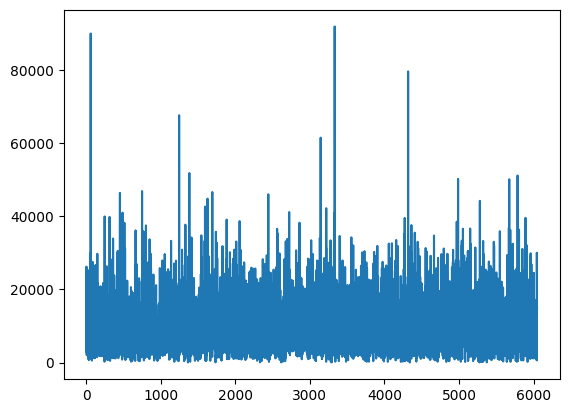

In [33]:
len(business_text1.split())

15335

In [16]:
len(np.unique(raw_data["ticker"], return_counts=True)[0])

6411

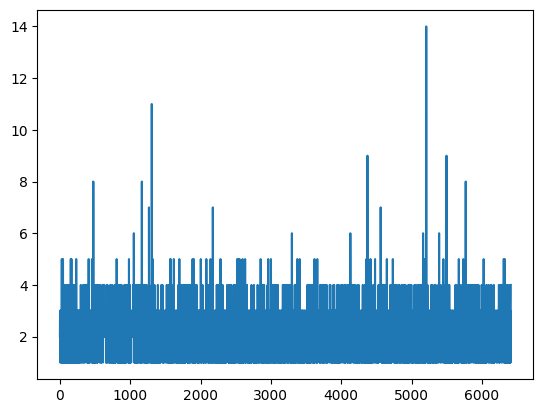

In [17]:
plt.plot(np.unique(raw_data["ticker"], return_counts=True)[1])

In [5]:
raw_data = pd.read_json("data/10k_filings.json")
data = raw_data.f0_[len(raw_data.f0_) - 2]

In [6]:
data

' ITEM 1. BUSINESS &#160; Overview Unless otherwise indicated by the context, all references in this Annual Report on Form 10-K to &#8220;we,&#8221; &#8220;us,&#8221; &#8220;our,&#8221; the &#8220;Company&#8221; or &#8220;Prestige&#8221; refer to Prestige Consumer Healthcare Inc. and our subsidiaries. Prior to August 17, 2018, the Company\'s name was Prestige Brands Holdings, Inc. Reference to a year (e.g., &#8220;2021&#8221;) refers to our fiscal year ended March 31 of that year. We formed as a Delaware corporation in 1996 and are engaged in the development, manufacturing, marketing, sales and distribution of well-recognized, brand name, over-the-counter (&#8220;OTC&#8221;) healthcare products to mass merchandisers, drug, food, dollar, convenience, club and e-commerce stores in North America (the United States and Canada) and in Australia and certain other international markets. We use the strength of our brands, our established retail distribution network, a low-cost operating model 

In [7]:

data_clean = re.sub('&#[0-9]*;*',' ', data)

In [8]:
data_clean

' ITEM 1. BUSINESS   Overview Unless otherwise indicated by the context, all references in this Annual Report on Form 10-K to  we,   us,   our,  the  Company  or  Prestige  refer to Prestige Consumer Healthcare Inc. and our subsidiaries. Prior to August 17, 2018, the Company\'s name was Prestige Brands Holdings, Inc. Reference to a year (e.g.,  2021 ) refers to our fiscal year ended March 31 of that year. We formed as a Delaware corporation in 1996 and are engaged in the development, manufacturing, marketing, sales and distribution of well-recognized, brand name, over-the-counter ( OTC ) healthcare products to mass merchandisers, drug, food, dollar, convenience, club and e-commerce stores in North America (the United States and Canada) and in Australia and certain other international markets. We use the strength of our brands, our established retail distribution network, a low-cost operating model and our experienced management team to our competitive advantage. Our ultimate success is

In [1]:
from sec_edgar_downloader import Downloader

In [2]:
# Initialize a downloader instance. If no argument is passed
# to the constructor, the package will download filings to
# the current working directory.
dl = Downloader("data/fillings")

# Get the latest 10-K filing for Microsoft
dl.get("10-K", "MSFT", amount=1)

/home/alfonso/Desktop/mia/tfm/venv/lib/python3.9/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


1

In [21]:
dataset_config = EDGARDataSetConfig(
    tickers_or_ciks=['amzn'],
    form_types=['10-K', '10-Q'],
    filing_date_start='2019-01-01',
    filing_date_end='2020-12-31',
    email_as_user_agent='test-user@test.com')

In [11]:
session = sagemaker.Session()
#bucket = session.default_bucket()
role = sagemaker.get_execution_role()

TypeError: 'NoneType' object is not subscriptable